In [1]:
import numpy as np
import networkx as nx
import node2vec.src.node2vec as node2vec
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
class Args:
    pass
args = Args()
args.weighted = False
args.input = '../test_edgelist.csv'
args.output = '../test_edgelist.emb'
args.directed = False
args.dimensions = 128
args.window_size = 10
args.workers = 8
args.iter = 1
args.p = 1
args.q = 1
args.num_walks = 10
args.walk_length = 80

In [3]:
# get edge list
def get_edge_list_from_nsbIR(majority_applied='super_majority'):
    df = pd.read_csv("../test_edgelist.csv")
    df_filtered = df[df[majority_applied] == 1]
    edge_list = df_filtered[['x', 'y']]
    return edge_list

In [4]:
def read_graph():
    '''
    Reads the input network in networkx.
    '''
    df_edge_list = get_edge_list_from_nsbIR()
    if args.weighted:
        G = nx.from_pandas_edgelist(df_edge_list, source='x', target='y', create_using=nx.DiGraph())
    else:
        G = nx.from_pandas_edgelist(df_edge_list, source='x', target='y', create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not args.directed:
        G = G.to_undirected()

    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.wv.save_word2vec_format(args.output)

In [5]:
# Pipeline for representational learning for all nodes in a graph.

nx_G = read_graph()
G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
G.preprocess_transition_probs()
walks = G.simulate_walks(args.num_walks, args.walk_length)
learn_embeddings(walks)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


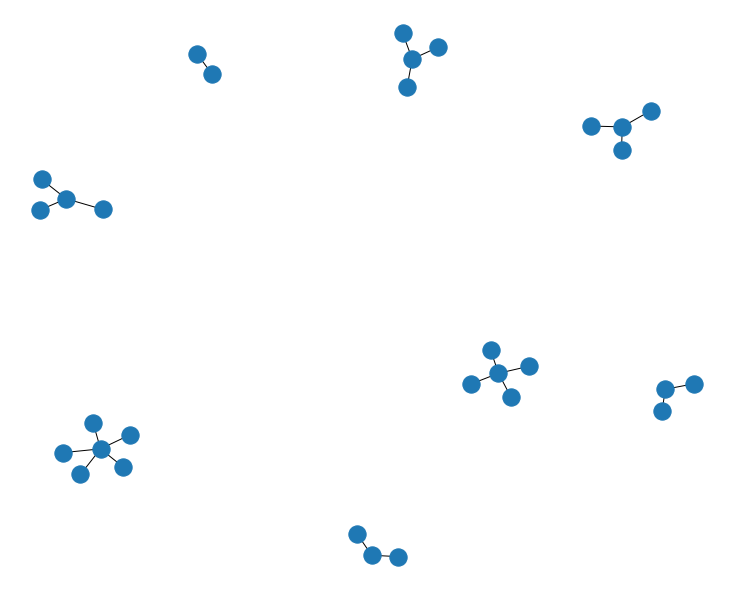

In [6]:
# plot inferred network
plt.figure(figsize=(10,8))
nx.draw(nx_G)

In [7]:
# Take a random sample of edges
edge_subset = random.sample(nx_G.edges(), int(0.25 * nx_G.number_of_edges()))

# Remove some edges
nx_G_train = nx_G.copy()
nx_G_train.remove_edges_from(edge_subset)

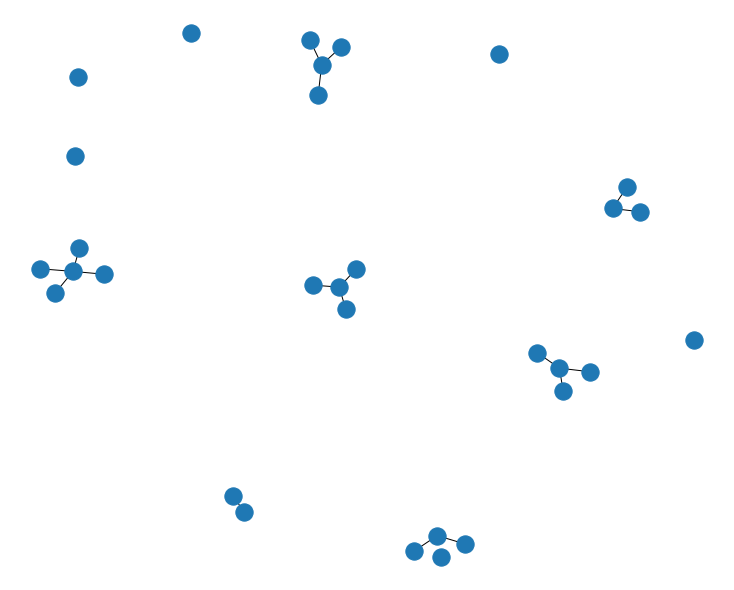

In [8]:
# Plot graph with edges removed
plt.figure(figsize=(10,8))
nx.draw(nx_G_train)